In [1]:
# Import necessary libraries
import pandas as pd
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# Define column names for the dataset
COL_NAMES = ['unit', 'cycle', 'operational setting 1', 'operational setting 2', 'operational setting 3'] + [f'sensor measurement {i}' for i in range(1, 26)]

# Define a list of features to exclude
EXCLUDE_FEATURES = []

### Preprocess data

In [3]:
def load_data(file_path):
    """
    The load_data function reads in a text file containing the data and returns a pandas DataFrame.
    
    :param file_path: Specify the location of the text file to be read
    :return: A pandas dataframe
    """
    df = pd.read_table(file_path, sep=' ', names=COL_NAMES) # Read data from the specified text file using pandas, specifying column names
    return df

def calculate_RUL(df):
    """
    The calculate_RUL function takes a DataFrame as input and returns the same DataFrame with an additional column called RUL.
    The RUL (Remaining Useful Life) is calculated for each row based on the maximum cycle for its corresponding unit.
    Columns with NaN values and constant columns are dropped from the returned DataFrame.
    
    :param df: Pass the dataframe to the function
    :return: A dataframe with rul calculated and irrelevant columns removed
    """
    max_cycle_per_unit = {} # Find the maximum cycle for each unit and store it in a dictionary
    for unit in df['unit'].unique():
        max_cycle_per_unit[unit] = df['cycle'].loc[df['unit'] == unit].max()

    df['RUL'] = df['unit'].apply(lambda nr: max_cycle_per_unit[nr]) - df['cycle'] # Calculate RUL for each row based on the maximum cycle for its corresponding unit
   
    # Drop columns with NaN values and constant columns
    cols_nan = df.columns[df.isna().any()].tolist()
    cols_const = [col for col in df.columns if len(df[col].unique()) <= 2]
    df = df.drop(columns=cols_const + cols_nan)
    
    # Return the DataFrame with RUL calculated and irrelevant columns removed
    return df

def rolling_mean_by_unit(df, n, verbose=False):
    """
    Calculate the rolling mean of sensor measurements for each unit in the dataset.

    :param df: Pass the dataframe to the function
    :param n: Determine the window size of the rolling mean
    :param verbose: Print the unit number that is currently being processed
    :return: A dataframe with the rolling mean of each unit
    """
    cols_sensors = [c for c in df.columns if c.startswith('s')] # Select columns corresponding to sensor measurements
    df_new = df.copy()
    unit_nrs = df['unit'].unique()

    # Iterate through each unit and calculate the rolling mean for sensor measurements
    for nr in unit_nrs:
        if verbose:
            print(f'processing unit nr: {nr}')
        idx = df['unit'] == nr
        df_new.loc[idx, cols_sensors] = df.loc[idx, cols_sensors].rolling(n, min_periods=1).mean()

    return df_new

def split_train_test(df, test_ratio=0.2):
    """
    Split the dataset into training and testing sets based on unit numbers.

    :param df: Pass the dataframe to the function
    :param test_ratio: Determine the proportion of units to be used for testing
    :return: A tuple of two dataframes, one for training and one for testing
    """
    units = df['unit'].unique()
    n_units = len(units)

    units_test = random.sample(list(units), int(n_units * test_ratio)) # Randomly select a portion of units for testing
    units_train = [nr for nr in units if nr not in units_test] # Remaining units are used for training

    df_test = df[df['unit'].isin(units_test)].copy()
    df_train = df[df['unit'].isin(units_train)].copy()

    return df_train, df_test

def backward_regression(X, y, threshold_out=0.05, verbose=True):
    """
    The backward_regression function performs backward feature selection by iteratively removing the worst performing feature at each stage, 
    until all remaining features perform better than a specified threshold. The function returns a list of the excluded features.

    :param X: Pass the dataframe of features to be used in the model
    :param y: Specify the target variable
    :param threshold_out: Determine the p-value threshold for exclusion
    :param verbose: Print the features that are removed from the model
    """
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit() # Fit OLS regression model with the current set of included features
        pvalues = model.pvalues.iloc[1:] # Extract p-values for each feature (excluding the constant term)
        worst_pval = pvalues.max()  # Identify the worst p-value (maximum p-value)

        # Check if the worst p-value exceeds the threshold for exclusion
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            EXCLUDE_FEATURES.append(worst_feature) 
        if not changed:
            break

def preprocess_data(df_train, df_test):
    """
    The preprocess_data function takes in the training and testing dataframes,
    and returns preprocessed training and testing data. The function also returns 
    the list of features used for preprocessing. The following steps are performed:

    :param df_train: Pass the training dataframe to the function
    :param df_test: Scale the test data with the same scaler as used for training
    Returns:
    - train_data: Scaled and preprocessed training features.
    - train_labels: Training labels (RUL).
    - test_data: Scaled and preprocessed testing features.
    - test_labels: Testing labels (RUL).
    - cols_features: List of selected features.
    """
    # Select features for preprocessing, excluding excluded features
    cols_features =  [c for c in df_train.columns if c.startswith('s') and c not in EXCLUDE_FEATURES]
    
    train_data = df_train[cols_features].values
    train_labels = df_train['RUL'].values

    test_data = df_test[cols_features].values
    test_labels = df_test['RUL'].values

    min_max_scaler = MinMaxScaler() # Use MinMaxScaler to scale the features to a specific range
    train_data = min_max_scaler.fit_transform(train_data)
    test_data = min_max_scaler.fit_transform(test_data)

    # Return preprocessed data and additional information
    return train_data, train_labels, test_data, test_labels, cols_features

def evaluate_model(model, X, y, set_name):
    """
    The evaluate_model function takes in a model, X and y data sets, and the name of the set.
    It then makes predictions using the model on the X data set. It calculates R-squared error 
    and Root Mean Squared Error (RMSE) metrics for that prediction. Finally it prints out those 
    metrics along with a label indicating which set they are for.

    :param model: Pass in the model we want to evaluate
    :param X: Input features
    :param y: True labels
    :param set_name: Print out the name of the set being evaluated
    """
    predictions = model.predict(X)# Make predictions using the model

    # Calculate R-squared and Root Mean Squared Error (RMSE) metrics
    r2 = model.score(X, y)
    rmse = mean_squared_error(y, predictions, squared=False)
    
    print(f'{set_name} Set Metrics:')
    print(f'R-squared error: {r2:.2%}')
    print(f'Root Mean Squared Error: {rmse:.2f}')

### Train dataset

In [4]:
# Load training data from 'train.txt' and preprocess it
train_file_path = 'train.txt'
df_train = load_data(train_file_path)

In [5]:
df_train.head()

,unit,cycle,operational setting 1,operational setting 2,operational setting 3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,...,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21,sensor measurement 22,sensor measurement 23,sensor measurement 24,sensor measurement 25
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,0.03,368,2319,100.0,28.58,17.1735,NaN,NaN,NaN,NaN
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,0.03,391,2388,100.0,38.99,23.3619,NaN,NaN,NaN,NaN
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,0.02,334,2223,100.0,14.83,8.8555,NaN,NaN,NaN,NaN
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,0.02,364,2324,100.0,24.42,14.7832,NaN,NaN,NaN,NaN
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,0.02,330,2212,100.0,10.99,6.4025,NaN,NaN,NaN,NaN


In [6]:
df_train = calculate_RUL(df_train)
df_train = rolling_mean_by_unit(df_train, 10)

In [7]:
df_train.head()

,unit,cycle,operational setting 1,operational setting 2,operational setting 3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,...,sensor measurement 11,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 17,sensor measurement 18,sensor measurement 20,sensor measurement 21,RUL
0,1,1,10.0047,0.2501,20.0,489.0500,604.1300,1499.450000,1309.950,10.520000,...,45.4000,372.150000,2388.130000,8120.830000,8.621600,368.000000,2319.0,28.580000,17.173500,222
1,1,2,0.0015,0.0003,100.0,503.8600,623.1300,1542.000000,1356.955,12.570000,...,46.3450,446.980000,2388.140000,8126.850000,8.506150,379.500000,2353.5,33.785000,20.267700,221
2,1,3,34.9986,0.8401,60.0,485.7200,600.5600,1484.056667,1278.800,10.206667,...,44.8700,359.073333,2388.076667,8105.846667,8.789333,364.333333,2310.0,27.466667,16.463633,220
3,1,4,20.0031,0.7005,0.0,487.0875,602.1775,1485.152500,1271.395,9.992500,...,44.7175,348.015000,2388.075000,8092.460000,8.897775,364.250000,2313.5,26.705000,16.043525,219
4,1,5,42.0041,0.8405,40.0,478.6700,591.6460,1459.018000,1241.980,8.776000,...,44.1320,304.500000,2388.038000,8090.702000,8.977940,357.400000,2293.2,23.562000,14.115320,218


In [8]:
df_train, df_test = split_train_test(df_train)

In [9]:
# Perform backward feature elimination
X = df_train.iloc[:, 1:-1]
y = df_train.iloc[:, -1]
backward_regression(X, y)

Train Set Metrics:
R-squared error: 72.13%
Root Mean Squared Error: 36.41
   Actual RUL  Predicted RUL
0         137        144.594
1         264        211.404
2          37         41.014
3         103        146.726
4          48         49.896


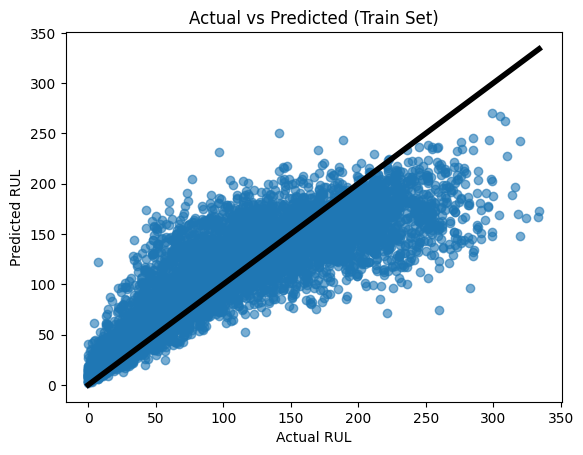

In [10]:
# Preprocess training and testing data
train_data, train_labels, test_data, test_labels, cols_features = preprocess_data(df_train, df_test)

# Split the training set into training and train sets
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# Train a Random Forest regression model
rf_model = RandomForestRegressor(n_jobs=-1,
                                 n_estimators=500,
                                 min_samples_leaf=1,
                                 max_features='sqrt').fit(X_train, y_train)

# Evaluate the model on the train set
evaluate_model(rf_model, X_val, y_val, 'Train')

# Create a DataFrame to compare actual and predicted RUL on the train set
results_df_train = pd.DataFrame({'Actual RUL': y_val, 'Predicted RUL': rf_model.predict(X_val)})
print(results_df_train.head())

# Visualize the model's predictions against actual RUL on the train set
plt.scatter(y_val, rf_model.predict(X_val), alpha=0.6)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='black', linewidth=4)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted (Train Set)')
plt.show()

### Test dataset

In [11]:
# Load test data from 'test.txt' and preprocess it
test_file_path = 'test.txt'
df_test_set = load_data(test_file_path)
df_test_set = calculate_RUL(df_test_set)
df_test1 = rolling_mean_by_unit(df_test_set, 10)

In [12]:
# Preprocess test data using the same features as the training set
test_data, test_labels, _, _, _ = preprocess_data(df_train, df_test_set)

# Evaluate the trained Random Forest model on the test set
evaluate_model(rf_model, test_data, test_labels, 'Test')

results_df_test = pd.DataFrame({'Actual RUL': test_labels, 'Predicted RUL': rf_model.predict(test_data)})
print(results_df_test.head())

Test Set Metrics:
R-squared error: 91.38%
Root Mean Squared Error: 20.20
   Actual RUL  Predicted RUL
0         222        199.358
1         221        203.250
2         220        202.032
3         219        198.630
4         218        153.908


### Final dataset

In [13]:
# Load final test data from 'final_test.txt' and preprocess it
final_test_file_path = 'final_test.txt'
df_final_test = load_data(final_test_file_path)
df_final_test = calculate_RUL(df_final_test)
df_final_test = rolling_mean_by_unit(df_final_test, 10)

Final Test Set Metrics:
R-squared error: 91.38%
Root Mean Squared Error: 20.20
   Actual RUL  Predicted RUL
0         222        199.358
1         221        203.250
2         220        202.032
3         219        198.630
4         218        153.908


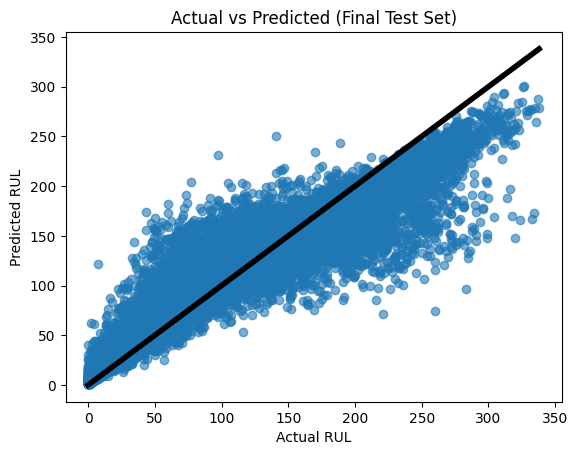

In [14]:
# Preprocess final test data using the same features as the training set
final_test_data, final_test_labels, _, _, _ = preprocess_data(df_train, df_final_test)

# Evaluate the trained Random Forest model on the final test set
evaluate_model(rf_model, final_test_data, final_test_labels, 'Final Test')

# Create a DataFrame to compare actual and predicted RUL on the final test set
results_df_final = pd.DataFrame({'Actual RUL': final_test_labels, 'Predicted RUL': rf_model.predict(final_test_data)})
print(results_df_final.head())

# Visualize the model's predictions against actual RUL on the final test set
plt.scatter(final_test_labels, rf_model.predict(final_test_data), alpha=0.6)
plt.plot([min(final_test_labels), max(final_test_labels)], [min(final_test_labels), max(final_test_labels)], color='black', linewidth=4)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted (Final Test Set)')
plt.show()

In [15]:
csv_file_path = 'predicted_rul_results.csv'
results_df_final.to_csv(csv_file_path, index=False)
print(f'The predicted RUL results have been saved to {csv_file_path}')

The predicted RUL results have been saved to predicted_rul_results.csv


### Conclusion

The provided evaluation metrics suggest that the trained Random Forest regression model performs well on both the train set, test set, and the final test set. Here are some conclusions:

    Train Set Metrics:

R-squared error of 72.13% indicates that the model explains about 72.13% of the variance in the train set.
Root Mean Squared Error (RMSE) of 36.41 suggests that, on average, the model's predictions deviate by approximately 36.41 units from the actual values in the train set.
Looking at the first few rows of the results DataFrame, the predicted RUL values generally follow the trend of the actual RUL values.

    Test Set Metrics:

R-squared error of 91.38% on the test set indicates a high level of explained variance by the model.
The lower RMSE of 20.20 compared to the validation set suggests that the model performs even better on the test set, with smaller prediction errors.
The first few rows of the results DataFrame for the test set show that the predicted RUL values closely match the actual RUL values.

    Final Test Set Metrics:

The metrics for the final test set are identical to those of the regular test set, indicating consistent performance.
The R-squared error and RMSE values are the same as those observed on the test set.
The results DataFrame for the final test set also displays close correspondence between predicted and actual RUL values.

In summary, the model generalizes well to both the test set and the final test set, providing accurate predictions with high explanatory power. The consistency in metrics between the test set and final test set suggests that the model is robust and performs well on previously unseen data.

### Ways to improve  the results:

1. Time Series Features: Extract more meaningful time-related features that can capture patterns over time.
2. Hyperparameter Tuning.
3. Data Cleaning: Clean the data by addressing missing values, outliers, and other anomalies that could affect model performance. 
4. External Data Integration: Consider incorporating external data that might provide additional information to enhance the model's predictive capabilities.
5. Regular Model Retraining: Periodically retrain the model with new data to ensure it remains accurate as the underlying patterns in the data may change over time.

